In [2]:
import pprint
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [3]:
pd.set_option( 'display.max_columns', 10 )
pd.set_option('precision', 6)
pd.set_option('max_colwidth', 20)
pd.set_option('display.width', 120)

## function infValue

In [31]:
def infValue( x, y, labels=(0,1), names=('Neg', 'Pos'), mins=(1,1), offsets=(0,0), verb=False ):

    a  = pd.crosstab( x, y ) 
    labs2keep=[g for g in a.columns if g in labels ]
    a = a[labs2keep]
    a.columns = names
    
    if sum(offsets) > 0 :
        a = a + offsets
    
    #  Create column containing Column Percentages
    pct_cols = ['Pct_'+b for b in a.columns]
    for i in range(len(a.columns)):
        a[pct_cols[i]]=round(a[a.columns[i]]/sum(a[a.columns[i]]), 4)
    
    a['use']       = np.where( np.logical_and( a[a.columns[0]] > mins[0], a[a.columns[1]] > mins[1]), 1, 0)
    a['woe']       = np.where( a['use'] == 1, np.log(a[a.columns[len(names)]]/a[a.columns[len(names)+1]]), 0)
    a['ivcontrib'] = (a[a.columns[len(names)]]-a[a.columns[len(names)+1]]) * a['woe' ]
  
    inf_val = sum( a['ivcontrib'] )
    
    if verb:
        print('Inf. value = '+ str(inf_val) + ', '+ str(sum(a['use'])) + ' of '+str(len(a['use'])) + ' levels contributing')
        print(a)
        
    return (inf_val, a)


In [75]:
def infValueEquibin( x, y, n=7, labels=(0,1), names=('Neg', 'Pos'), mins=(1,1), verb=False):

    #n = np.min([np.max([n,3]),7])
    
    xx = pd.qcut( x, n, duplicates='drop')    
    #xx = pd.qcut( x, n, duplicates='drop').apply(lambda x: x.left).astype(float) 
    #pd.qcut( x, n, duplicates='drop').apply(lambda x: x.right).astype(int) 
    a = pd.crosstab( xx, y ) 
    a = a.sort_index( 0 )     #  To ensure ascending order
    labs2keep=[g for g in a.columns if g in labels ]
    a = a[labs2keep]
    a.columns = names

    ''' 
	 From this point on merely repeats the code in infValue
	 We can either call infValue with 'xx' instead of 'x'
	 But a better aproach is to consolidate the below code into core functionality
	 That leaves the door open to extend it to compute Mututal information.
	 That code will not need to know anything about how the grouping is done, which is perfect!
    '''

    #  Create column containing Column Percentages
    pct_cols = ['Pct_'+ b for b in a.columns]
    for i in range(len(a.columns)):
        a[pct_cols[i]]=a[a.columns[i]]/sum(a[a.columns[i]])
    
	#  The below line should be a loop to handle any number of class labels
    a['use']       = np.where( np.logical_and( a[a.columns[0]] > mins[0], a[a.columns[1]] > mins[1]), 1, 0)
    a['woe']       = np.where( a['use'] == 1, np.log(a[a.columns[len(names)]]/a[a.columns[len(names)+1]]), 0)
    a['ivcontrib'] = (a[a.columns[len(names)]]-a[a.columns[len(names)+1]]) * a['woe' ]
  
    inf_val = sum( a['ivcontrib'] )
    
    if verb:
        print('Inf. value = '+ str(inf_val) + ', '+ str(sum(a['use'])) + ' of '+str(len(a['use'])) + ' levels contributing')
        print(a)
        
    return (inf_val, a)

In [57]:
def cr_woe_iv(df, l_col, pr_typ, verb = False,  draw_ind = False):
    """
    module name : cr_woe_iv
    Purpose: 
    1. Invoke "infValue/infValueEquibin" to create
       - dfx: A data frame for feature values, woe and ivcontrib
       - ivx: Information value (sum of ivcontrib)
    2. Create a list l_sum to sum up column value for 'Approved','Declined', 'Pct_Approved', 'Pct_Declined', and ' ivcontrib'  
       - Not calculate the sum for 'use' and 'Woe'
    Parameters
      input: 
        df: data frame to calculate woe and iv
        l_col: list of columns to calculate woe and iv
        pr_tpy: Process type 
          obj: Process woe and iv for object features
          num: Process woe and iv for numeric features 
        verb: Indicator to verbose
        draw_ind: Indicator to draw the plot for woe
      output:
        dfy: data frame to capture value counts of 'Apprroved', counts of 'Declined', 'Pct_Approved', 'Pct_Declined', and ' ivcontrib'  
        dfz: data frame to capture  feature name of iv
    """
    l_iv=[]
    col_dfx = ['Approved',  'Declined',  'Pct_Approved', 'Pct_Declined'] 

    dfy = pd.DataFrame()
    for fea in l_col:
            # print(f'fea, {fea}')
            if pr_typ == 'obj':
               (ivx, dfx) =  infValue( df[fea],   df['target'], verb= verb, mins=( 1,1), names=('Approved','Declined') )
            else:
               (ivx, dfx) = infValueEquibin( df[fea], df['target'], n=7, verb= verb, mins=(1,1), names=('Approved','Declined') )
            
            if draw_ind:
               plt.plot( dfx.woe); plt.grid()
            # get sum    
            l_sum = ['', 'Total']
            l_sum.extend([dfx[col].sum() for col in col_dfx ]) # sum up column value for 'Approved','Declined', 'Pct_Approved', 'Pct_Declined'
            l_sum.extend(['', '']) # not calculate 'use' and 'Woe'
            l_sum.append( round(dfx['ivcontrib'].sum(), 4))  # add IV
            
            l_fea = [fea] + [''] + ['' for x in dfx.columns]
            columns=['feature'] + ['value'] + dfx.columns.tolist()
            df0 = pd.DataFrame([l_fea],columns=columns)
            
            dfx = dfx.reset_index()
            dfx.rename(columns={fea:'value'},inplace = True)
            dfx.insert(loc=0, column='feature', value = '')
            
            dfx.loc[len(dfx)] = l_sum
            dfy = pd.concat([dfy,  df0, dfx], axis = 0)
            l_iv.append([fea, round(ivx, 4)]) 
    df_iv = pd.DataFrame(l_iv,columns=['feature','iv'])  
    return df_iv,  dfy

In [93]:
def f_adj_col_sheet(pdf_nm, excel_writer,sheet_nm, head_fmt_ind):    
    """
      module name : f_adj_col_sheet
      purpose     : Based on the column names and content of columns to adjust the spreadsheet column length
                     - Return workbook with adjusted column length 
      parameters     :
        pdf_nm       : panda data frame name for the excel sheet
        excel_writer : XlsxWriter Excel object
        sheet_nm     : sheet name
        head_fmt_ind : indictor to define head format for the workbook  
      Note: 
        The calling program needs to define the xcel_writer with engine='xlsxwriter', e.g.
        - writer = pd.ExcelWriter(excel_file, engine='xlsxwriter')
    """    
    workbook  = excel_writer.book
    worksheet = excel_writer.sheets[sheet_nm]
    if ( head_fmt_ind == 'True'):
         header_format = workbook.add_format({
             'bold': True,
             'text_wrap': True,
             'valign': 'top',
             'bg_color': 'grey', 
             'border': 1})        
                 
    _col = 'A'

    #worksheet.show_gridlines(True)
    for col in pdf_nm.columns.values:        
         max_col_cnt =  max(pdf_nm[col].apply(repr).apply(len).max(), len(col))
         col_rang =  _col + ':' + _col 
         worksheet.set_column(col_rang , max_col_cnt) + 2
         _col = chr(ord(_col) + 1)  
    #worksheet.hide_gridlines(False)    
    worksheet.setGridlinesVisible(True) 
    return workbook

In [8]:
path = 'C:\\Users\\sophia.yue\\Infosys\\Sandeep Project\\'
df = pd.read_excel(path + "INFOSYS_POPULATION_22sep22.xlsx", sheet_name = 'INFOSYS_POPULATION_new', engine = 'openpyxl' )
df.head(3).T

,0,1,2
Org_Struc_Desc,Corporation,Partnership,Non-Profit
NAICS_Cd,238160,621210,813319
NAICS_Desc,Roofing Contractors,Offices of Dentists,Other Social Adv...
Revw_Id,117882,118031,119338
Revw_Month,2019/01,2019/01,2019/02
Revw_Quarter,2019/1,2019/1,2019/1
Decision,Approved,Declined,Approved
Scored_Flag,N,N,N
Elan_Flag,N,N,N
CLI_or_New_Prod_Flag,Y,Y,N


In [68]:
df.drop('Decision', axis = 1,  inplace = True)
           

In [53]:
l_col_obj = df.dtypes[df.dtypes == 'O'].index.tolist() 
l_col_obj_rem = ['NAICS_Desc', 'Revw_Month', 'Revw_Quarter']
l_col_obj = [ x for x in l_col_obj if x not in l_col_obj_rem]
card_typ = ['Corporate_Card','Purchasing_Card','One_Card','Other_NonBankCard']
l_col_obj.extend(card_typ)
print(l_col_obj)

['Org_Struc_Desc', 'Decision', 'Scored_Flag', 'Elan_Flag', 'CLI_or_New_Prod_Flag', 'Channel', 'Scored_Rec_Decision', 'Financial_Template_Found_Flag', 'Corporate_Card', 'Purchasing_Card', 'One_Card', 'Other_NonBankCard']


In [9]:
df.head()
df.shape
df.describe()
df.info()
#  Examine target values and map to 0 and 1
df.Decision.value_counts()             
targ_dict = {'Declined': 1, 'Approved':0 }
df['target'] = [targ_dict[yy] for yy in df.Decision]
df.target.value_counts() 
df.drop('Decision', axis = 1,  inplace = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2483 entries, 0 to 2482
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Org_Struc_Desc                 2483 non-null   object 
 1   NAICS_Cd                       2483 non-null   int64  
 2   NAICS_Desc                     2483 non-null   object 
 3   Revw_Id                        2483 non-null   int64  
 4   Revw_Month                     2483 non-null   object 
 5   Revw_Quarter                   2483 non-null   object 
 6   Decision                       2483 non-null   object 
 7   Scored_Flag                    2483 non-null   object 
 8   Elan_Flag                      2483 non-null   object 
 9   CLI_or_New_Prod_Flag           2483 non-null   object 
 10  Channel                        2481 non-null   object 
 11  Corporate_Card                 2483 non-null   int64  
 12  Purchasing_Card                2483 non-null   i

0    1850
1     633
Name: target, dtype: int64

In [23]:
l_col_num = df.dtypes[df.dtypes != 'O'].index.tolist() 
l_col_num_rem = ['NAICS_Cd', 'Revw_Id', 'Revw_Quarter', 'target'] + card_typ
l_col_num = [ x for x in l_col_num if x not in l_col_num_rem]
print(l_col_num)

['SBFE_Score', 'CC_Score', 'Existing_Limit', 'Request_Amount', 'Final_Limit']


In [6]:
df.dtypes[df.dtypes != 'O']

NAICS_Cd               int64
Revw_Id                int64
Corporate_Card         int64
Purchasing_Card        int64
One_Card               int64
Other_NonBankCard      int64
SBFE_Score           float64
CC_Score             float64
Existing_Limit         int64
Request_Amount         int64
Final_Limit            int64
target                 int64
dtype: object

In [60]:

df_iv_obj, df_woe_obj = cr_woe_iv(df, l_col_obj,pr_typ = 'obj', verb = False, draw_ind = False)
df_iv_num, df_woe_num = cr_woe_iv(df, l_col_num,pr_typ = 'num', verb = False, draw_ind = False)
df_iv = pd.concat([df_iv_obj, df_iv_num], ignore_index = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [63]:
df_woe_obj.head(10)

,feature,value,Approved,Declined,Pct_Approved,Pct_Declined,use,woe,ivcontrib
0,Org_Struc_Desc,,,,,,,,
0,,Corporation,907,349,0.49027,0.551343,1,-0.1174,0.00717
1,,LLC,402,218,0.217297,0.344392,1,-0.460513,0.058529
2,,MSA Av Consumer,1,0,0.000541,0.0,0,0.0,0.0
3,,Non-Profit,474,45,0.256216,0.07109,1,1.282074,0.237346
4,,Other,10,4,0.005405,0.006319,1,-0.15618,0.000143
5,,Partnership,56,15,0.03027,0.023697,1,0.244831,0.001609
6,,Sole Proprietorship,0,2,0.0,0.00316,0,0.0,-0.0
7,,Total,1850,633,1.0,1.0,,,0.3048
0,Decision,,,,,,,,


In [94]:
path_file = 'C:\\Users\\sophia.yue\\Infosys\\Sandeep Project\\usb_woe.xlsx'
writer = pd.ExcelWriter(path_file)
sheet_name = 'woe'
df_woe_num.to_excel(writer, sheet_name = sheet_name, index = False, float_format = "%.4f" )
f_adj_col_sheet(df_woe_num, writer, sheet_name, True)
writer.save()

In [ ]:


                    
sd =  df[fea].value_counts()/len(df)
df2 = sd.to_frame(name='ratio_cnt').reset_index()
df2.rename(columns={'index':'value'}, inplace = True)
df3 = df1.merge(df2, on = 'value',how = 'inner')
dfy = pd.concat([dfy,  df0, df3], axis = 0)

## Calculate WOE from cross_tab 

In [ ]:
import pandas as pd
import numpy as np
from pandas import ExcelWriter
from pandas import ExcelFile

In [ ]:

path_file = "C:\\Users\\sophia.yue\\Infosys\\Sandeep Project\\wip Payment Audit Modeling 20180130 v1.xlsx"
df = pd.read_excel(path_file, engine = 'openpyxl', sheet_name = 'WoE_wip', index_col ='Value')
dfx = df.copy()

In [144]:
round(dfx['ivcontrib'].sum(), 4)

0.0001

In [ ]:
df = dfx.copy()
(inf, dfy) = inf_value( df , verb=True )

In [85]:
fea

'Other_NonBankCard'

In [88]:
 (ivx, dfx) =  infValuex( df[fea],   df['target'], verb= verb, mins=( 1,1), names=('Approved','Declined') )

TypeError: type numpy.ndarray doesn't define __round__ method

In [87]:
def infValuex( x, y, labels=(0,1), names=('Neg', 'Pos'), mins=(1,1), offsets=(0,0), verb=False ):

    a  = pd.crosstab( x, y ) 
    labs2keep=[g for g in a.columns if g in labels ]
    a = a[labs2keep]
    a.columns = names
    
    if sum(offsets) > 0 :
        a = a + offsets
    
    #  Create column containing Column Percentages
    pct_cols = ['Pct_'+b for b in a.columns]
    for i in range(len(a.columns)):
        a[pct_cols[i]]=round(a[a.columns[i]]/sum(a[a.columns[i]]), 4)
    
    a['use']       = np.where( np.logical_and( a[a.columns[0]] > mins[0], a[a.columns[1]] > mins[1]), 1, 0)
    a['woe']       = round(np.where( a['use'] == 1, np.log(a[a.columns[len(names)]]/a[a.columns[len(names)+1]]), 0), 4)
  
    inf_val = round(sum( a['ivcontrib'] ), 4)
    
    if verb:
        print('Inf. value = '+ str(inf_val) + ', '+ str(sum(a['use'])) + ' of '+str(len(a['use'])) + ' levels contributing')
        print(a)
        
    return (inf_val, a)

In [149]:
dfz = dfx.copy()
dfz.insert(loc=0, column='feature', value = '')
dfz

,feature,Approved,Declined,Pct_Approved,Pct_Declined,use,woe,ivcontrib
Other_NonBankCard,,,,,,,,
0,,1830,626,0.989189,0.988942,1,0.000250,6.200406e-08
1,,19,7,0.010270,0.011058,1,-0.073942,5.827946e-05
2,,1,0,0.000541,0.000000,0,0.000000,0.000000e+00


In [ ]:
df['pct_ total'] = (df.Passed + df.Failed)/(df['Passed'].sum() + df.Failed.sum() )

In [129]:
verb = True
(ivx, dfx) =  infValue( df[fea],   df['target'], verb= verb, mins=( 1,1), names=('Approved','Declined') )
l_sum = [df.col.sum() for col in dfx.columns ]

Inf. value = 5.834146057233561e-05, 2 of 3 levels contributing
                   Approved  Declined  Pct_Approved  Pct_Declined  use       woe     ivcontrib
Other_NonBankCard                                                                             
0                      1830       626      0.989189      0.988942    1  0.000250  6.200406e-08
1                        19         7      0.010270      0.011058    1 -0.073942  5.827946e-05
2                         1         0      0.000541      0.000000    0  0.000000  0.000000e+00


AttributeError: 'DataFrame' object has no attribute 'col'

In [155]:
l_iv = []
l_iv.append([fea, round(ivx,4)])
#df_iv = pd.DataFrame(dic_iv)
dfz.loc[len(dfz)] = l_iv
dfz

ValueError: cannot set a row with mismatched columns

In [163]:
l_sum

['', 'Total', 1850, 633, 0.9999999999999999, 1.0, '', '', 0.3048]

In [164]:
dfx.columns

Index(['values', 'Approved', 'Declined', 'Pct_Approved', 'Pct_Declined', 'use', 'woe', 'ivcontrib'], dtype='object')

In [152]:
dic_iv = {}
dic_iv.update({fea:round(ivx,4)})
df_iv = pd.DataFrame(dic_iv)
df_iv

ValueError: If using all scalar values, you must pass an index

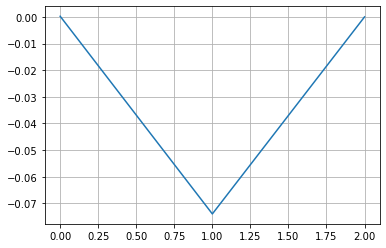

In [157]:

plt.plot( dfx.woe); plt.grid()

In [176]:
df_iv

,feature,iv
0,Org_Struc_Desc,0.3048


In [36]:
"""
1. Invoke "infValue" to
   - dfx data frame for labels, oe and ivcontrib
   - iv4: Information value (sum of ivcontrib)
2. Create a list l_sum to sum up column value for 'Approved','Declined', 'Pct_Approved', 'Pct_Declined', and ' ivcontrib'  
   - # not calculate 'use' and 'Woe'
"""
l_iv=[]
l_col_obj = ['Other_NonBankCard']
col_dfx = ['Approved',  'Declined',  'Pct_Approved', 'Pct_Declined'] 
draw_ind = False
dfy = pd.DataFrame()
verb= True
for fea in l_col_obj:
        (ivx, dfx) =  infValue( df[fea],   df['target'], verb= verb, mins=( 1,1), names=('Approved','Declined') )
        
        if draw_ind:
           plt.plot( dfx.woe); plt.grid()
        # get sum    
        l_sum = ['', 'Total']
        l_sum.extend([dfx[col].sum() for col in col_dfx ]) # sum up column value for 'Approved','Declined', 'Pct_Approved', 'Pct_Declined'
        l_sum.extend(['', '']) # not calculate 'use' and 'Woe'
        l_sum.append( round(dfx['ivcontrib'].sum(), 4))  # add IV
        
        l_fea = [fea] + [''] + ['' for x in dfx.columns]
        columns=['feature'] + ['value'] + dfx.columns.tolist()
        df0 = pd.DataFrame([l_fea],columns=columns)
        
        dfx = dfx.reset_index()
        dfx.rename(columns={fea:'value'},inplace = True)
        dfx.insert(loc=0, column='feature', value = '')
        
        dfx.loc[len(dfx)] = l_sum
        dfy = pd.concat([dfy,  df0, dfx], axis = 0)
        l_iv.append([fea, round(ivx, 4)]) 
df_iv = pd.DataFrame(l_iv,columns=['feature','iv'])      

Inf. value = 5.834146057233561e-05, 2 of 3 levels contributing
                   Approved  Declined  Pct_Approved  Pct_Declined  use       woe     ivcontrib
Other_NonBankCard                                                                             
0                      1830       626      0.989189      0.988942    1  0.000250  6.200406e-08
1                        19         7      0.010270      0.011058    1 -0.073942  5.827946e-05
2                         1         0      0.000541      0.000000    0  0.000000  0.000000e+00


In [178]:
dfy

,feature,value,Approved,Declined,Pct_Approved,Pct_Declined,use,woe,ivcontrib
0,Org_Struc_Desc,,,,,,,,
0,,Corporation,907,349,0.49027,0.551343,1,-0.1174,0.00717
1,,LLC,402,218,0.217297,0.344392,1,-0.460513,0.058529
2,,MSA Av Consumer,1,0,0.000541,0.0,0,0.0,0.0
3,,Non-Profit,474,45,0.256216,0.07109,1,1.282074,0.237346
4,,Other,10,4,0.005405,0.006319,1,-0.15618,0.000143
5,,Partnership,56,15,0.03027,0.023697,1,0.244831,0.001609
6,,Sole Proprietorship,0,2,0.0,0.00316,0,0.0,-0.0
7,,Total,1850,633,1.0,1.0,,,0.3048
0,Channel,,,,,,,,


In [10]:
df.dtypes[df.dtypes == 'O'].index.tolist() 

['Org_Struc_Desc',
 'NAICS_Desc',
 'Revw_Month',
 'Revw_Quarter',
 'Decision',
 'Scored_Flag',
 'Elan_Flag',
 'CLI_or_New_Prod_Flag',
 'Channel',
 'Scored_Rec_Decision',
 'Financial_Template_Found_Flag']

In [11]:
df.dtypes[df.dtypes != 'O'].index.tolist() 

['NAICS_Cd',
 'Revw_Id',
 'Corporate_Card',
 'Purchasing_Card',
 'One_Card',
 'Other_NonBankCard',
 'SBFE_Score',
 'CC_Score',
 'Existing_Limit',
 'Request_Amount',
 'Final_Limit',
 'target']

In [48]:
def crx_woe_iv(df, l_col, pr_typ, verb = False,  draw_ind = False):
    """
    module name : cr_woe_iv
    Purpose: 
    1. Invoke "infValue/infValueEquibin" to create
       - dfx: A data frame for feature values, woe and ivcontrib
       - ivx: Information value (sum of ivcontrib)
    2. Create a list l_sum to sum up column value for 'Approved','Declined', 'Pct_Approved', 'Pct_Declined', and ' ivcontrib'  
       - Not calculate the sum for 'use' and 'Woe'
    Parameters
      input: 
        df: data frame to calculate woe and iv
        l_col: list of columns to calculate woe and iv
        pr_tpy: Process type 
          obj: Process woe and iv for object features
          num: Process woe and iv for numeric features 
        verb: Indicator to verbose
        draw_ind: Indicator to draw the plot for woe
      output:
        dfy: data frame to capture value counts of 'Apprroved', counts of 'Declined', 'Pct_Approved', 'Pct_Declined', and ' ivcontrib'  
        dfz: data frame to capture  feature name of iv
    """
    l_iv=[]
    col_dfx = ['Approved',  'Declined',  'Pct_Approved', 'Pct_Declined'] 

    dfy = pd.DataFrame()
    for fea in l_col:
            print(f'fea, {fea}')
            if pr_typ == 'obj':
               (ivx, dfx) =  infValue( df[fea],   df['target'], verb= verb, mins=( 1,1), names=('Approved','Declined') )
            else:
               infValueEquibin( df[fea], df['target'], n=7, verb= verb, mins=(1,1), names=('Approved','Declined') )
            
            if draw_ind:
               plt.plot( dfx.woe); plt.grid()
            # get sum    
            l_sum = ['', 'Total']
            l_sum.extend([dfx[col].sum() for col in col_dfx ]) # sum up column value for 'Approved','Declined', 'Pct_Approved', 'Pct_Declined'
            l_sum.extend(['', '']) # not calculate 'use' and 'Woe'
            l_sum.append( round(dfx['ivcontrib'].sum(), 4))  # add IV
            l_sum
            l_fea = [fea] + [''] + ['' for x in dfx.columns]
            columns=['feature'] + ['value'] + dfx.columns.tolist()
            df0 = pd.DataFrame([l_fea],columns=columns)
            print(f'df0')
            dfx = dfx.reset_index()
            dfx.rename(columns={fea:'value'},inplace = True)
            dfx.insert(loc=0, column='feature', value = '')
            print(f'dfx')
            dfx.loc[len(dfx)] = l_sum
            dfy = pd.concat([dfy,  df0, dfx], axis = 0)
            print(f'dfy')
            l_iv.append([fea, round(ivx, 4)]) 
            print(f'dfz l_iv {l_iv}')
    df_iv = pd.DataFrame(l_iv,columns=['feature','iv']) 
    return df_iv, dfy

Inf. value = 0.1895606559517924, 7 of 7 levels contributing
                  Approved  Declined  Pct_Approved  Pct_Declined  use       woe  ivcontrib
SBFE_Score                                                                                
(89.999, 859.0]        174       135      0.117014      0.247706    1 -0.749950   0.098013
(859.0, 877.0]         192       106      0.129119      0.194495    1 -0.409674   0.026783
(877.0, 891.429]       203        61      0.136516      0.111927    1  0.198602   0.004884
(891.429, 906.0]       240        62      0.161399      0.113761    1  0.349774   0.016662
(906.0, 921.0]         232        55      0.156019      0.100917    1  0.435674   0.024006
(921.0, 940.0]         225        68      0.151311      0.124771    1  0.192863   0.005119
(940.0, 1566.0]        221        58      0.148621      0.106422    1  0.333990   0.014094
Inf. value = 0.027365949729322922, 7 of 7 levels contributing
                   Approved  Declined  Pct_Approved  Pct_De

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:405: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:405: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:405: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:405: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and

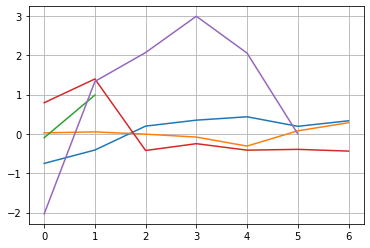

In [77]:

df_iv_num, df_owe_num = cr_woe_iv(df, l_col_num,pr_typ = 'num', verb = True, draw_ind = True)

In [69]:
df.columns

Index(['Org_Struc_Desc', 'NAICS_Cd', 'NAICS_Desc', 'Revw_Id', 'Revw_Month', 'Revw_Quarter', 'Scored_Flag', 'Elan_Flag',
       'CLI_or_New_Prod_Flag', 'Channel', 'Corporate_Card', 'Purchasing_Card', 'One_Card', 'Other_NonBankCard',
       'Scored_Rec_Decision', 'SBFE_Score', 'CC_Score', 'Financial_Template_Found_Flag', 'Existing_Limit',
       'Request_Amount', 'Final_Limit', 'target'],
      dtype='object')

In [ ]:
SLA    Saervice Level Agreement
SOW    Statement of Work
DAQC   Data Analytics Quality Control
ECMO   Enterprise Complaint Management Office
LBP    Look Back period
CRGC   Customer Remediation Governance Committee
CRCD   Customer Remediation Customer Database
ADCON  Address Confidentiality
CRCOE  Customer Remediation Center of Excellence